In [257]:
#check librosa stft and istft
import os
import sys
import numpy as np
import copy
import scipy
sys.path.insert(0, "/home/anonymous/Desktop/eeg_sampling/modeling")
from dataio import readdata2, readlabels2, writedata
from datafilters import apply_dc_filter, apply_dwt_filter, apply_stfft_filter

In [315]:
#Hyperparams

#DC Filter
enable_dc = True
dc_lowcut = 1.0
dc_highcut = 13.0
dc_order = 2
dc_type = "bandpass"
dc_func_type = "butter"

#DWT Filter
enable_dwt = False
dwt_type = "db2"
dwt_level = 4
dwt_thresh_func = "soft"
dwt_thresh_type = "rigrsure"

#STFT Filter
enable_fft = False
fft_window = 0.50
fft_step = 0.25
fft_thresh = 2.0
fft_set_thresh = 0.0

In [316]:
#predataset = readdata2("./../curated/raw-presamples")
dataset = readdata2("./../curated/raw-samples")
labels = readlabels2("./../curated/raw-inputs")
#Constants
fs = 250.0 #Frequency in Hz
sample_time = dataset[0].shape[1]/fs #Total time for sample
#presample_time = predataset[0].shape[1]/fs #Total time for sample
num_rows = 480 
num_channels = 8

In [317]:
total_samples = 0
for k in range(0, len(dataset)):
    #predataset[k].flags['WRITEABLE'] = True
    dataset[k].flags['WRITEABLE'] = True
    total_samples += dataset[k].shape[0]
    for i in range(0,dataset[k].shape[0]):
        for j in range(0,dataset[k].shape[2]):
            if enable_dc:
                #predataset[k][i,:,j] = apply_dc_filter(predataset[k][i,:,j], fs, dc_lowcut, dc_highcut, dc_order, dc_type, dc_func_type)
                dataset[k][i,:,j] = apply_dc_filter(dataset[k][i,:,j], fs, dc_lowcut, dc_highcut, dc_order, dc_type, dc_func_type)
            if enable_dwt:
                #predataset[k][i,:,j] = apply_dwt_filter(predataset[k][i,:,j], dwt_type, dwt_level, dwt_thresh_func, dwt_thresh_type)
                dataset[k][i,:,j] = apply_dwt_filter(dataset[k][i,:,j], dwt_type, dwt_level, dwt_thresh_func, dwt_thresh_type)
            if enable_fft:
                #predataset[k][i,:,j] = apply_stfft_filter(predataset[k][i,:,j], fs, presample_time, fft_window, fft_step, fft_thresh, fft_set_thresh)
                dataset[k][i,:,j] = apply_stfft_filter(dataset[k][i,:,j], fs, sample_time, fft_window, fft_step, fft_thresh, fft_set_thresh)
            #Normalize
            #dataset[k][i,:,j] = dataset[k][i,:,j]/np.linalg.norm(dataset[k][i,:,j])
            #predataset[k][i,:,j] = predataset[k][i,:,j]/np.linalg.norm(predataset[k][i,:,j])
            #np.mean(predataset[k][i,:,j])

In [318]:
#test_idx = [16]
test_idx = np.random.random_integers(0,len(dataset)-1,1)
test_dataset = dataset.pop(test_idx[0])
test_labels = labels.pop(test_idx[0])

train_dataset = np.concatenate(dataset)
train_dataset.shape = (total_samples - test_dataset.shape[0], num_rows, num_channels)
train_labels = np.concatenate(labels)

In [319]:
import matplotlib
matplotlib.use('Agg')
%matplotlib inline
import matplotlib.pyplot as plt

import pylab
from scipy import signal
from shortfft import stft, istft

/usr/lib64/python3.4/site-packages/matplotlib/__init__.py:1320: UserWarning:  This call to matplotlib.use() has no effect
because the backend has already been chosen;
matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)


In [320]:
from time import clock
from scipy.signal import hilbert
from scipy import interpolate
from math import log, ceil, floor
from numpy import abs, arange, shape, array, ceil, zeros, conj, ix_, transpose, append, fft, real, float64, linspace, sqrt

def nextpow2(n):
    return 2 ** ceil(log(n,2))

def disprog(i, N, steps):
    global begin_time_disprog
    if i == 0:
        begin_time_disprog = clock()
    if i == (N-1):
        print("100 %% complete in %f seconds." % (clock() - begin_time_disprog))
        del begin_time_disprog
    elif (floor(i * steps / float(N)) != floor((i-1) * steps / float(N))):
        print("%d" % (floor(i * steps / flaot(N)) * ceil(100.0 / float(steps))))
        
def wvd(audioFile, t=None, N=None, trace=0, make_analytic=True):
    if make_analytic:
        x = hilbert(audioFile)
    else:
        x = array(audioFile)
    
    if x.ndim == 1: [xrow, xcol] = shape(array([x]))
    else: raise ValueError("Signal x must be one-dimensional.")
        
    if t is None: t = arange(len(x))
    if N is None: N = len(x)
        
    if (N <= 0): raise ValueError("Number of Frequency bins N must be greater than zero.")
    
    if t.ndim == 1: [trow, tcol] = shape(array([t]))
    else: raise ValueError("Time indices t must be one-dimensional.")
    
    if xrow != 1:
        raise ValueError("Time indices t must have one row.")
    if trow != 1:
        raise ValueError("Time indicies t must have one row.")
    elif nextpow2(N) != N:
        print("For a faster computation, number of Frequency bins N should be a power of two.")
    
    tfr = zeros([N, tcol], dtype="complex")
    if trace: print("Wigner-Ville distribution"),
    for icol in range(0, tcol):
        ti = t[icol]
        taumax = min([ti, xcol-ti-1, int(round(N/2.0))-1])
        tau = arange(-taumax, taumax+1)
        indices = ((N+tau)%N)
        tfr[ix_(indices, [icol])] = transpose(array(x[ti+tau] * conj(x[ti-tau]), ndmin=2))
        tau=int(round(N/2))+1
        if ((ti+1) <= (xcol-tau)) and ((ti+1) >= (tau+1)):
            if(tau >= tfr.shape[0]): tfr = append(tfr, zeros([1, tcol]), axis=0)
            tfr[ix_([tau], [icol])] = array(0.5 * (x[ti+tau] * conj(x[ti-tau]) + x[ti-tau] * conj(x[ti+tau])))
        if trace: disprog(icol, tcol, 10),
            
    tfr = real(fft.fft(tfr, axis=0))
    f = 0.5*arange(N)/float(N)
    return (transpose(tfr), t, f)

def filtered_wvd(wvd, stft):
    qstft = abs(stft)
    qstft = float64(qstft * qstft)
    bigstft = zeros(shape[wvd[0]], float64)
    
    x = arange(0, shape(qstft)[0])
    y = arange(0, shape(sqtft)[1])
    
    xx = linspace(x.min(), x.max(), shape(wvd[0])[0])
    yy = linspace(y.min(), y.max(), shape(wvd[0])[1])
    
    interpolator = interpolate.RectBivariateSpline(x,y,qstft, kx=1, ky=1)
    
    bigstft = interpolator(xx,yy)
    
    return (sqrt(abs(bigstft * wvd[0])), wvd[1], wvd[2])

In [321]:
temp = wvd(train_dataset[1,:,0])

For a faster computation, number of Frequency bins N should be a power of two.


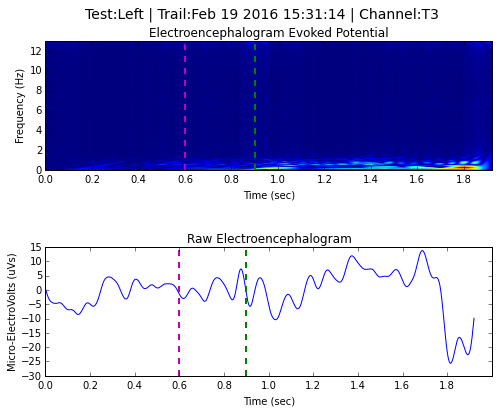

In [322]:
visual_cue = 0.6
sensory_offset = 0.3
im = temp[0].T
#im = np.delete(im, np.arange(200, 480), 0)

#Plots for comparison
plt.figure(1)
plt.figure(figsize=(8,6))
plt.suptitle("Test:Left | Trail:Feb 19 2016 15:31:14 | Channel:T3", fontsize = 14)

plt.subplot(211)
plt.title('Electroencephalogram Evoked Potential')
extent = [0, sample_time, 0, dc_highcut]
plt.imshow(scipy.absolute(im), extent=extent, origin='lower', aspect='auto', interpolation='bicubic')
#plt.imshow(scipy.absolute(im), origin='lower', aspect='auto', interpolation='bicubic')
plt.xticks(np.arange(0,sample_time,0.2))
plt.xlabel("Time (sec)")
plt.ylabel("Frequency (Hz)")

plt.axvline(visual_cue, linewidth=2, color='m', linestyle="--")
plt.axvline(visual_cue+sensory_offset, linewidth=2, color='g', linestyle="--")
#plt.colorbar()

plt.subplot(212);
plt.title('Raw Electroencephalogram')
plt.plot(np.linspace(0,sample_time,train_dataset[1,:,0].shape[0]),train_dataset[1,:,0])
plt.xticks(np.arange(0,sample_time,0.2))
plt.xlabel("Time (sec)")
plt.ylabel("Micro-ElectroVolts (uVs)")

plt.axvline(visual_cue, linewidth=2, color='m', linestyle="--")
plt.axvline(visual_cue+sensory_offset, linewidth=2, color='g', linestyle="--")

#plt.tight_layout()
plt.subplots_adjust(hspace=0.6)
plt.show()

In [277]:
import csv
with open('image.csv', 'w', newline='\n') as fp:
    a = csv.writer(fp, delimiter=',')
    a.writerows(temp[0].T)

with open('raweeg.csv', 'w', newline='\n') as fp:
    a = csv.writer(fp, delimiter=',')
    a.writerows(['data',train_dataset[1,:,0]])

In [117]:
temp[0].T

array([[  171.29513036,   248.04177577,   389.066162  , ...,
         2459.60422806,  1625.18808255,   490.35530221],
       [  171.29513036,   246.17716944,   385.19555862, ...,
         2491.7685464 ,  1634.32720021,   490.35530221],
       [  171.29513036,   244.28018235,   381.18364227, ...,
         2523.32457726,  1643.29927069,   490.35530221],
       ..., 
       [  171.29513036,   253.43814329,   399.80560302, ...,
         2359.64014592,  1596.78424742,   490.35530221],
       [  171.29513036,   251.67257375,   396.3735455 , ...,
         2393.52187   ,  1606.41499782,   490.35530221],
       [  171.29513036,   249.87368183,   392.79295953, ...,
         2426.84933183,  1615.88348366,   490.35530221]])

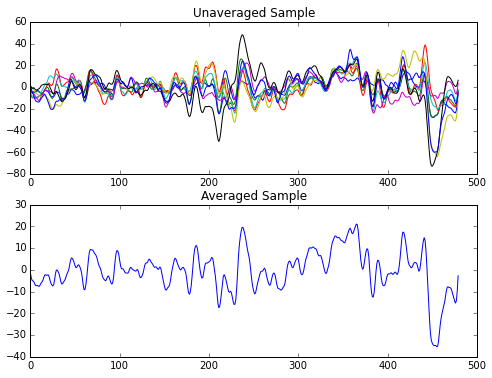

In [142]:
#Plots for comparison
plt.figure(1);
plt.figure(figsize=(8,6));

#Presample signal
plt.subplot(211);
for i in range(0,train_dataset.shape[2]):
    plt.plot(train_dataset[1,:,i]);
plt.title("Unaveraged Sample")

#Presample signal
plt.subplot(212);
train_dataset_avg = np.mean(train_dataset, axis=2)
plt.plot(train_dataset_avg[1,:]);
plt.title("Averaged Sample")

In [162]:
temp = wvd(train_dataset_avg[,:])

For a faster computation, number of Frequency bins N should be a power of two.


For a faster computation, number of Frequency bins N should be a power of two.


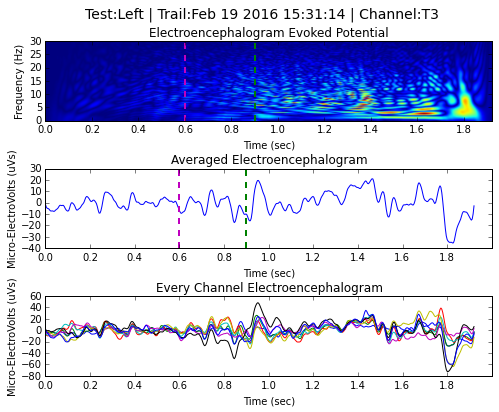

In [202]:
num = 1
temp = wvd(train_dataset_avg[num,:])
visual_cue = 0.6
sensory_offset = 0.3
im = temp[0].T
im = np.delete(im, np.arange(100, 480), 0)

#Plots for comparison
plt.figure(1)
plt.figure(figsize=(8,6))
plt.suptitle("Test:Left | Trail:Feb 19 2016 15:31:14 | Channel:T3", fontsize = 14)

plt.subplot(311)
plt.title('Electroencephalogram Evoked Potential')
extent = [0, sample_time, 0, dc_highcut]
plt.imshow(scipy.absolute(im), extent=extent, origin='lower', aspect='auto', interpolation='bicubic')
plt.xticks(np.arange(0,sample_time,0.2))
plt.xlabel("Time (sec)")
plt.ylabel("Frequency (Hz)")

plt.axvline(visual_cue, linewidth=2, color='m', linestyle="--")
plt.axvline(visual_cue+sensory_offset, linewidth=2, color='g', linestyle="--")
#plt.colorbar()

plt.subplot(312)
plt.title('Averaged Electroencephalogram')
plt.plot(np.linspace(0,sample_time,train_dataset_avg[num,:].shape[0]),train_dataset_avg[num,:])
plt.xticks(np.arange(0,sample_time,0.2))
plt.xlabel("Time (sec)")
plt.ylabel("Micro-ElectroVolts (uVs)")

plt.axvline(visual_cue, linewidth=2, color='m', linestyle="--")
plt.axvline(visual_cue+sensory_offset, linewidth=2, color='g', linestyle="--")

plt.subplot(313)
plt.title('Every Channel Electroencephalogram')
for i in range(0,train_dataset.shape[2]):
    plt.plot(np.linspace(0,sample_time,train_dataset[num,:,i].shape[0]),train_dataset[num,:,i])
plt.xticks(np.arange(0,sample_time,0.2))
plt.xlabel("Time (sec)")
plt.ylabel("Micro-ElectroVolts (uVs)")
#plt.tight_layout()
plt.subplots_adjust(hspace=0.6)
plt.show()

In [170]:
import pywt

def apply_dwt_filter(y, dwt_type, dwt_level, dwt_thresh_func, dwt_thresh_type):
    coeffs = pywt.wavedecn(y, dwt_type, level=dwt_level)
    for i in range(1, dwt_level+1):
        coeffs[i]["d"] = pywt.threshold(coeffs[i]["d"], thselect(coeffs[i]["d"], dwt_thresh_type), dwt_thresh_func)
    return(pywt.waverecn(coeffs, dwt_type))

In [188]:
dwt_type = "db2"
dwt_level = 4
dwt_thresh_func = "soft"
dwt_thresh_type = "rigrsure"

(cA4, cD4, cD3, cD2, cD1) = pywt.wavedecn(train_dataset_avg[num,:], dwt_type, level=dwt_level)

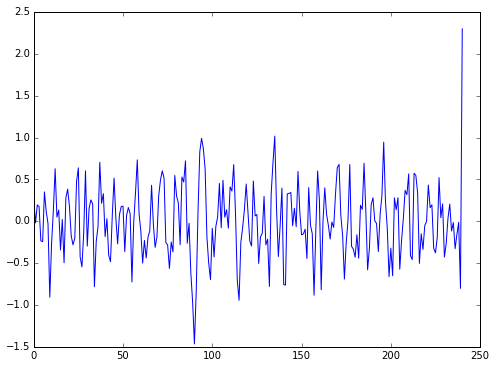

In [185]:
#Plots for comparison
plt.figure(1)
plt.figure(figsize=(8,6))
plt.plot(coeffs[4]["d"])

In [180]:
print(train_dataset_avg.shape)

(447, 480)


For a faster computation, number of Frequency bins N should be a power of two.


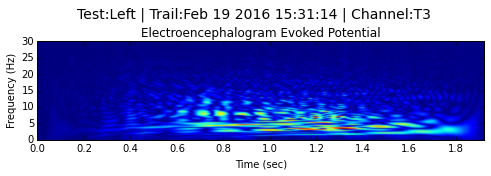

In [195]:
temp = wvd(train_dataset_avg[num,:])
visual_cue = 0.6
sensory_offset = 0.3
im = temp[0].T
im = np.delete(im, np.arange(100, 480), 0)

#Plots for comparison
plt.figure(1)
plt.figure(figsize=(8,6))
plt.suptitle("Test:Left | Trail:Feb 19 2016 15:31:14 | Channel:T3", fontsize = 14)

plt.subplot(311)
plt.title('Electroencephalogram Evoked Potential')
extent = [0, sample_time, 0, dc_highcut]
plt.imshow(scipy.absolute(im), extent=extent, origin='lower', aspect='auto', interpolation='bicubic')
plt.xticks(np.arange(0,sample_time,0.2))
plt.xlabel("Time (sec)")
plt.ylabel("Frequency (Hz)")